<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Графики-общие" data-toc-modified-id="Графики-общие-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Графики общие</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Стационарность-ряда" data-toc-modified-id="Стационарность-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Стационарность ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Новые-признаки" data-toc-modified-id="Новые-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Новые признаки</a></span></li><li><span><a href="#Дневная-сезонность" data-toc-modified-id="Дневная-сезонность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дневная сезонность</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки" data-toc-modified-id="Разделение-выборки-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Разделение выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Недельная-сезонность" data-toc-modified-id="Недельная-сезонность-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Недельная сезонность</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки" data-toc-modified-id="Разделение-выборки-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Разделение выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Далее будет построена модель для такого предсказания.

В качестве метрики качества будет выступать *RMSE* (значение метрики RMSE на тестовой выборке должно быть не больше 48).

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Откроем и изучим файл с информацией о заказах такси в аэропортах.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit, 
    cross_val_score, 
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', sep=',')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В базе данных 26496 наблюдений. Мы видим, что первый столбец с датой имеет формат object, что неверно. Перекодируем столбец "datetime" в формат даты и сделаем его индексом. Проверим, в хронологическом ли порядке расположены наблюдения в таблице.

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
print("Отсортирована ли таблица:", df.index.is_monotonic)
print(df.head())

Отсортирована ли таблица: True
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Так как нам нужно спрогнозировать количество заказов такси на следующий час, выполним ресемплирование данных по одному часу и сохраним изменения.

In [5]:
df = df.resample('1H').sum()

Данные загружены и преобразованы, можно приступить к анализу.

## Анализ

### Графики общие

Построим график на ресемплированных по часу данных.

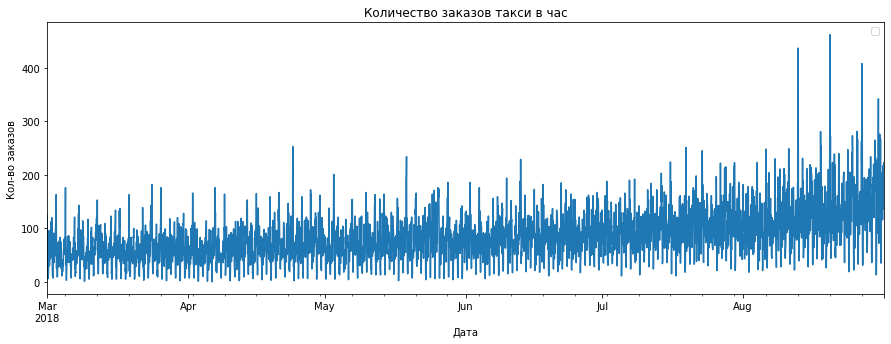

In [6]:
df.plot(title = 'Количество заказов такси в час', figsize=(15, 5))
plt.xlabel('Дата')
plt.legend('')
plt.ylabel('Кол-во заказов');

Данных очень много, смотреть не очень удобно, но виден восходящий тренд - после августа количество заказов такси увеличивается.

**Выполним ресемплирование данных по дням.** Сохраним ресемплированные данные в отдельную переменную, она понадобится позже:

In [7]:
df_day = df.resample('1D').sum()

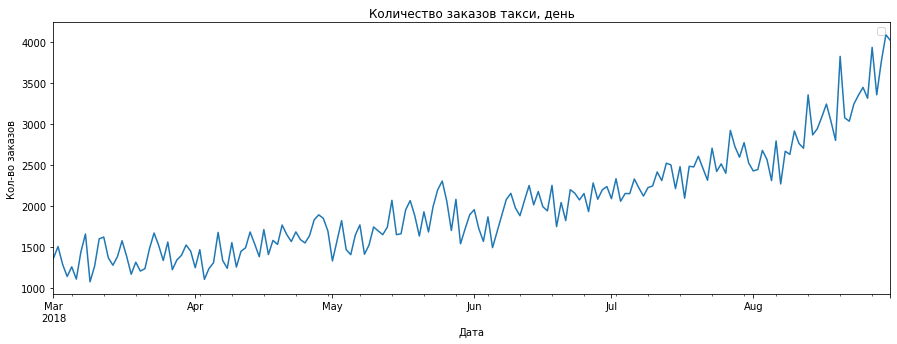

In [8]:
df_day.plot(title = 'Количество заказов такси, день', figsize=(15, 5))
plt.xlabel('Дата')
plt.legend('')
plt.ylabel('Кол-во заказов');

На данном графике заказы такси увеличиваются и уменьшаются волнами в течение месяца. Всего около 8 пиков за месяц (4 сдвоенных). В августе они заметны сильнее - сильнее колебания и количество заказов такси больше.

Выполним ресемплирование данных по неделе:

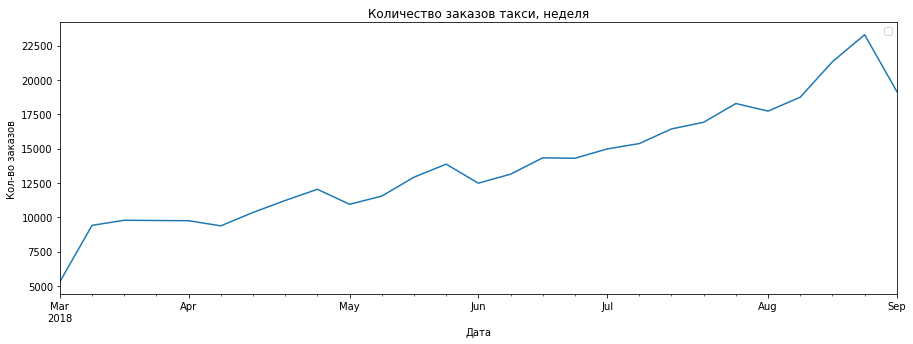

In [9]:
df.resample('1W').sum().plot(title = 'Количество заказов такси, неделя', figsize=(15, 5))
plt.xlabel('Дата')
plt.legend('')
plt.ylabel('Кол-во заказов');

При таком агрегированнии данных стал заметен пик - в конце августа, к началу сентября количество заказов такси из аэропорта значительно возрастает, а затем падает. Можно предположить, что это связано с возвращающимися из отпуска семьями, которые спешат вернуться домой к началу учебного года.

Укрупним данные, выполним ресемплирование данных по месяцу:

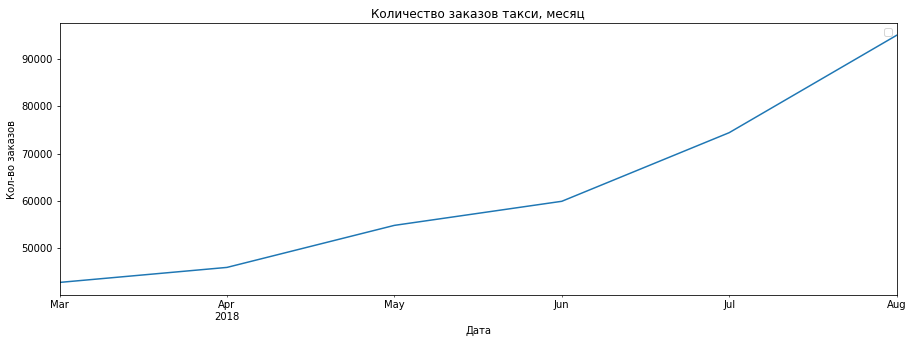

In [10]:
df.resample('1M').sum().plot(title = 'Количество заказов такси, месяц', figsize=(15, 5))
plt.xlabel('Дата')
plt.legend('')
plt.ylabel('Кол-во заказов');

С марта по сентябрь кол-во заказов такси увеличивается. Особенно резко - после июня, наверное, это также связано с началом сезона отпусков.

### Тренды и сезонность

Разложим временной ряд на тренд, сезонную компоненту и остаток. Посмотрим их графики.

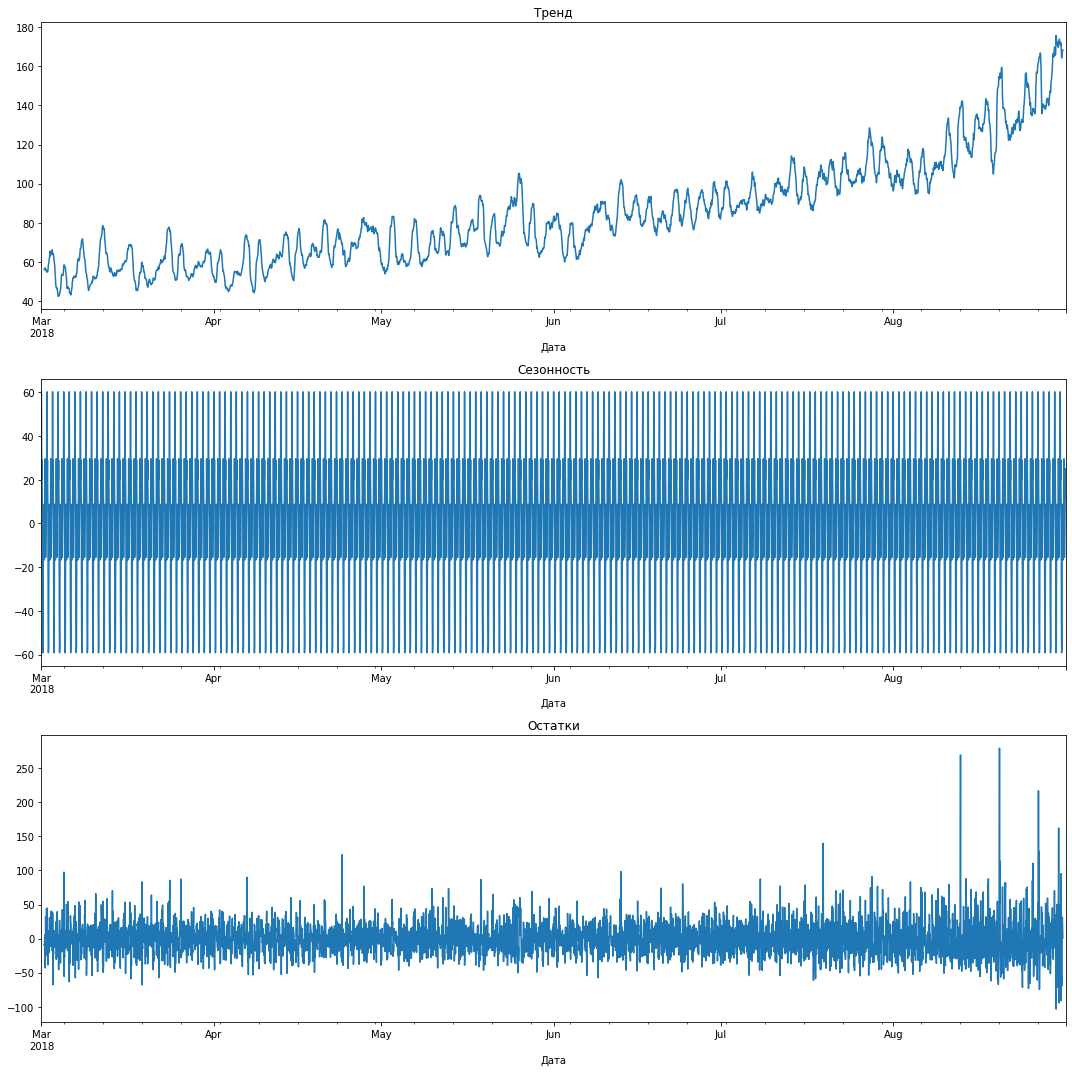

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.tight_layout()

На графиках видно, что тренд действительно восходящий - количество заказов в день увеличивается от марта к сенябрю. При этом есть четко выраженная сезонность - на графике много сезонных колебаний, но сделать выводы трудно, так как их очень много, рассмотри сезонный компонент подробнее ниже.
Количество "остатков" - данных, которые не объясняются трендом и сезонностью,увеличивается к сентябрю. Действительно, на общем графике заметны большие колебания количества заказов в этом периоде.

Рассмотрим сезонную компоненту подробнее - за одну неделю:

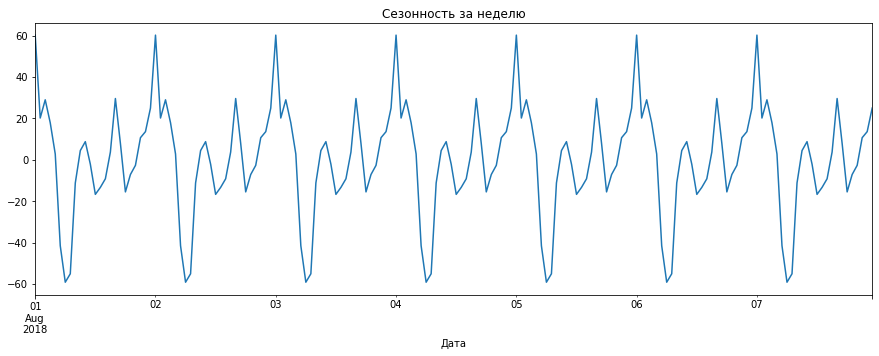

In [12]:
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Сезонность за неделю')
plt.xlabel('Дата');

В течении недели колебания количества заказов повторяются - они похожи изо дня в день, поэтому построим график сезонности только за один день.

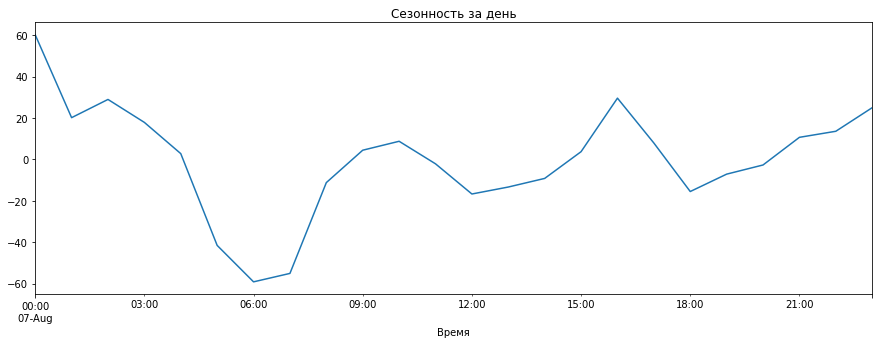

In [13]:
decomposed.seasonal['2018-08-07':'2018-08-07'].plot(ax=plt.gca(), figsize=(15, 5))
plt.title('Сезонность за день')
plt.xlabel('Время');

Пик заказов приходится на полночь. К 6 утра количество заказов такси уменьшается до минимума. Следующие высокие значения - после 9 и 15 часов.

### Стационарность ряда

Посмотрим, является ли наш временной ряд стационарным, то есть рядом, у которого среднее и стандартное отклонение не меняются. Стационарные ряды легче прогнозировать, чем нестационарные. Для этого найдем скользящее среднее и скользящее стандартное отклонение.

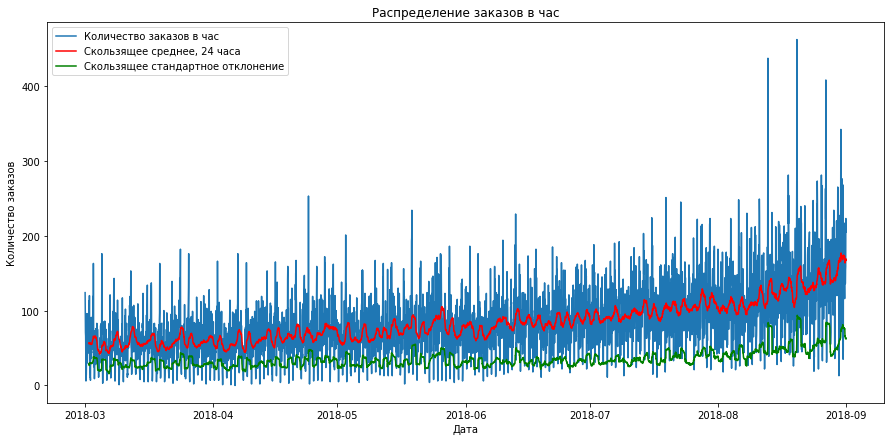

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='red')
plt.plot(df.rolling(24).std(), color='green')
plt.title('Распределение заказов в час')
plt.legend(['Количество заказов в час', 'Скользящее среднее, 24 часа', 'Скользящее cтандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Рассматриваемый временной ряд не является стационарным. Во-первых, изменяется скользящее среднее - увеличивается к концу рассматриваемого периода. Во-вторых, увеличиваются колебания стандартного отклонения также ближе к сентябрю. Проверим качество прогноза данных далее.

В данных мы увидели четко выраженную сезонность - количество заказов повторяется каждые сутки (24 часа). Временной ряд не является стационарным - после августа увеличивается скользящее среднее и скользящее стандартное отклонение.

In [15]:
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

Для прогнозирования количества заказов такси на следующий час рассмотрим три модели - линейную регрессию, случайный лес и модель градиентного бустинга - CatBoost. Данные будут разделены на обучающую и тестовую выборки, размер тестовой выборки - 10%.

### Новые признаки

Создадим новые признаки перед обучением моделей.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

### Дневная сезонность

Лаг и скользящее среднее указываем в размере суток, внутри которых заметны сезонные колебания

In [17]:
df_hour = make_features(df, 24, 24) 

In [18]:
df.head(2)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


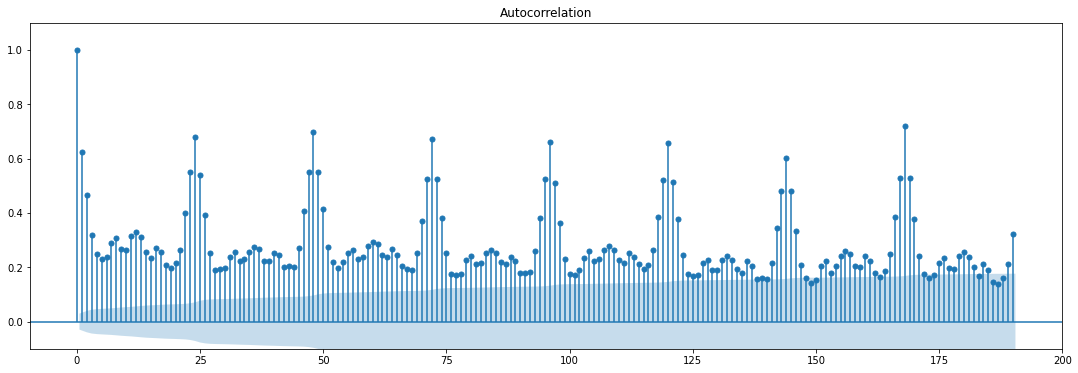

In [19]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



#### Разделение выборки

Разделим данные на выборки, выделим целевой и остальные признаки.

In [20]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Выборки не перемешались, идем дальше.

#### Линейная регрессия

Используем кросс-валидацию для оценки качества модели.

In [21]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train)
model_lr = LinearRegression() 
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv)
print (f'RMSE линейная регрессия: {round(np.mean(-score_lr), 2)}')

RMSE линейная регрессия: 27.13
CPU times: user 342 ms, sys: 605 ms, total: 947 ms
Wall time: 908 ms


#### Случайный лес

In [22]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train)
model_forest = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=1234), param_distributions={
    'n_estimators': range(10, 100),
    'max_depth': range(2, 15)}, scoring='neg_root_mean_squared_error', random_state=12345, cv=cv)

model_forest_fit = model_forest.fit(features_train, target_train)
model_forest_rmse = model_forest_fit.best_score_

print('RMSE случайный лес:', round(abs(model_forest_rmse),2))
print('Оптимальные значения параметров:', model_forest_fit.best_params_)

RMSE случайный лес: 25.33
Оптимальные значения параметров: {'n_estimators': 72, 'max_depth': 14}
CPU times: user 35.9 s, sys: 150 ms, total: 36 s
Wall time: 36.9 s


#### CatBoost

In [23]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train)
model_cat = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1234), param_distributions={
    'iterations': range(10, 100),
    'depth': range(2, 15)}, scoring='neg_root_mean_squared_error', random_state=12345, cv=cv)

model_cat_fit = model_cat.fit(features_train, target_train, verbose = False)
model_cat_rmse = model_cat_fit.best_score_

print('RMSE CatBoostRegressor:', round(abs(model_cat_rmse),2))
print('Оптимальные значения параметров:', model_cat_fit.best_params_)

RMSE CatBoostRegressor: 25.66
Оптимальные значения параметров: {'iterations': 32, 'depth': 6}
CPU times: user 7min 34s, sys: 18.9 s, total: 7min 53s
Wall time: 8min 54s


Все три модели показали примерно одинаковое качество. Хуже всего работает модель линейной регрессии - показатель RMSE равен почти 27.13. Это на 2 пункта выше, чем у случайного леса и CatBoost, RMSE которых почти одинаков.

Лучше всего отработала модель случайного леса с RMSE 25.29 и следующими параметрами: 'n_estimators': 72, 'max_depth': 14.

### Недельная сезонность

Возьмем другие параметры - 168 лагов (24*7).

In [24]:
df_day = make_features(df, 168, 168)

#### Разделение выборки

Разделим данные на выборки, выделим целевой и остальные признаки.

In [25]:
train_day, test_day = train_test_split(df_day, shuffle=False, test_size=0.1)
train_day = train_day.dropna()

print(train_day.index.min(), train_day.index.max())
print(test_day.index.min(), test_day.index.max())

features_train_day = train_day.drop('num_orders', axis=1)
target_train_day = train_day['num_orders']
features_test_day = test_day.drop('num_orders', axis=1)
target_test_day = test_day['num_orders']

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Выборки не перемешались, идем дальше.

#### Линейная регрессия

In [26]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train_day)
model_lr_day = LinearRegression() 
score_lr_day = cross_val_score(model_lr_day, features_train_day, target_train_day, scoring='neg_root_mean_squared_error', cv=cv)
print (f'RMSE линейная регрессия: {round(np.mean(-score_lr_day), 2)}')

RMSE линейная регрессия: 22.59
CPU times: user 563 ms, sys: 953 ms, total: 1.52 s
Wall time: 1.46 s


#### Случайный лес

In [27]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train_day)
model_forest_day = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=1234), param_distributions={
    'n_estimators': range(10, 100),
    'max_depth': range(2, 15)}, scoring='neg_root_mean_squared_error', random_state=12345, cv=cv)

model_forest_fit_day = model_forest_day.fit(features_train_day, target_train_day)
model_forest_rmse_day = model_forest_fit_day.best_score_

print('RMSE случайный лес:', round(abs(model_forest_rmse_day),2))
print('Оптимальные значения параметров:', model_forest_fit_day.best_params_)

RMSE случайный лес: 23.12
Оптимальные значения параметров: {'n_estimators': 72, 'max_depth': 14}
CPU times: user 3min 25s, sys: 285 ms, total: 3min 26s
Wall time: 3min 27s


#### CatBoost

In [28]:
%%time

cv = TimeSeriesSplit(n_splits=5).split(features_train_day)
model_cat_day = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1234), param_distributions={
    'iterations': range(10, 100),
    'depth': range(2, 15)}, scoring='neg_root_mean_squared_error', random_state=12345, cv=cv)

model_cat_fit_day = model_cat_day.fit(features_train_day, target_train_day, verbose = False)
model_cat_rmse_day = model_cat_fit_day.best_score_

print('RMSE CatBoostRegressor:', round(abs(model_cat_rmse_day),2))
print('Оптимальные значения параметров:', model_cat_fit_day.best_params_)

RMSE CatBoostRegressor: 23.69
Оптимальные значения параметров: {'iterations': 25, 'depth': 3}
CPU times: user 49min 55s, sys: 24.2 s, total: 50min 20s
Wall time: 51min 5s


Три модели показали примерно одинаковое качество, но лучше всех отработала модель линейной регрессии с метрикой качества 22.59. Проверим ее на тестовой выборке.

## Тестирование

Проверим, как себя ведет модель линейной регрессии на тестовой выборке.

In [35]:
%%time

model_lr = LinearRegression()
model_lr_fit = model_lr.fit(features_train_day, target_train_day)
model_lr_predictions = model_lr.predict(features_test_day)
print('RMSE на тестовой выборке', round(np.sqrt(((model_lr_predictions - target_test_day) ** 2).mean()),2))

RMSE на тестовой выборке 34.78
CPU times: user 131 ms, sys: 207 ms, total: 338 ms
Wall time: 315 ms


Посмотрим, насколько хорошо предсказания модели повторяют график заказов такси.

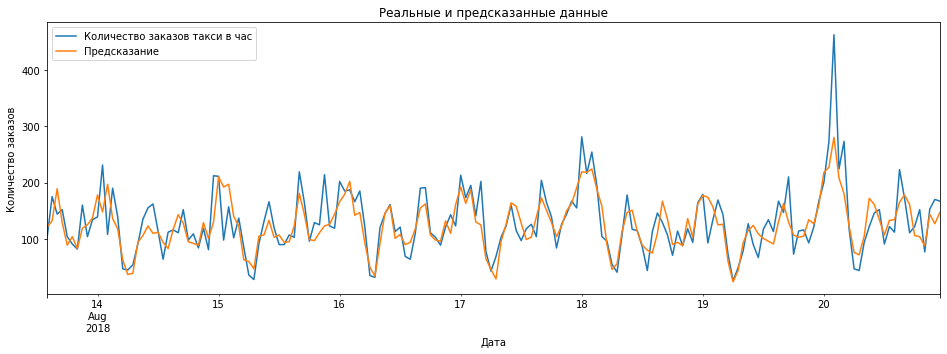

In [36]:
graph = target_test.copy()
predictions_taxi = pd.DataFrame(data = model_lr_predictions, columns = ['predictions'], index = features_test_day.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-13':'2018-08-20'].plot(figsize=(16,5))
plt.title('Реальные и предсказанные данные')
plt.legend(['Количество заказов такси в час', 'Предсказание'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

На графике видно, что предсказания модели хорошо повторяют реальные данные.

RMSE на тестовой выборке увеличился и стал равен 34.78. По условия задачи показатель не должен быть выше 48, что было выполнено с помощью модели линейной регрессии.

Стоить отметить, что модель хуже предсказывает пиковые значения, часто их недооценивает. Правда, модель корректно предсказывает сам факт повышенного спроса на такси, что должно быть особенно важно заказчику исследования.

**Проверка на адекватность**

Сравним качество предсказания "глупой" модели с качеством предсказания нашей подобранной модели.

In [37]:
pred_previous = target_test_day.shift()
pred_previous.iloc[0] = target_train_day.iloc[-1]
print('RMSE проверка на адекватность', round(np.sqrt(((pred_previous - target_test_day) ** 2).mean()),2))

RMSE проверка на адекватность 58.86


Показатель качества RMSE в данном случае равен 58.86, что намного выше нашей модели, значит, модель линейной регрессии работает хорошо.

## Вывод

Данные о заказах такси в аэропортах были открыты и обработаны. Было выполнено ресемплирование данных по одному часу, присвоены и проверены индексы.

В данных мы увидели четко выраженную сезонность - количество заказов повторяется каждые сутки (24 часа) и каждую неделю. Временной ряд не является стационарным - после августа увеличивается скользящее среднее и скользящее стандартное отклонение.

Для прогнозирования количества заказов такси на следующий час рассмотрено три модели - линейная регрессия, случайный лес и модель градиентного бустинга - CatBoost. Данные разделены на обучающую и тестовую выборки, размер тестовой выборки - 10%.

Три модели были применены с учетом сезонности - по дням и неделям. Лучше всего отработали модели с учетом сезонности по неделям. Все три модели показали примерно одинаковое качество. Лучше всего работает модель линейной регрессии - показатель RMSE равен почти 22.59. 

Для тестирования была выбрана модель линейной регрессии. RMSE на тестовой выборке увеличился и стал равен 34.78, что соответствует условию задачи.

Стоить отметить, что модель хуже предсказывает пиковые значения, часто их недооценивает. Правда, модель корректно предсказывает сам факт повышенного спроса на такси, что должно быть особенно важно заказчику исследования.